In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from datasets.jasper_ridge import input_processing

In [3]:
import cv2
img_path = 'data/jasper/jasper_ridge_224.mat'
gt_path = 'data/jasper/jasper_ridge_gt.mat'
start_band = 380; end_band = 2500
rgb_width = 64; rgb_height = 64
hsi_width = 32; hsi_height = 32
img_sri, img_rgb, gt = input_processing(img_path, gt_path, start_band, end_band)
img_hsi = img_sri#cv2.pyrDown(img_sri, dstsize=(50, 50))

In [4]:
print(img_hsi.shape, img_rgb.shape, gt.shape)

(100, 100, 224) (100, 100, 3) (100, 100, 4)


In [5]:
import numpy as np

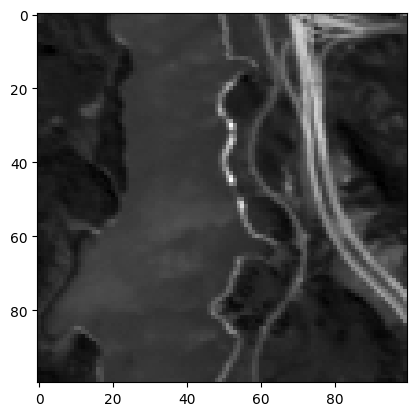

In [6]:
plt.imshow(img_hsi[:, :, 20], cmap="gray")
plt.show()

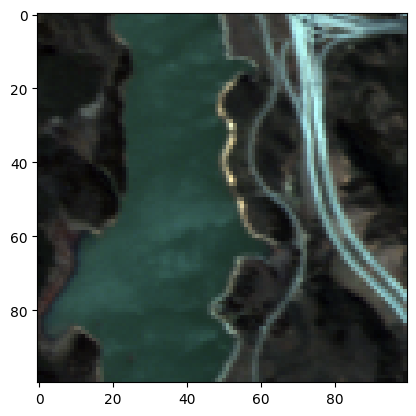

In [7]:
plt.imshow(img_rgb)
plt.show()

In [8]:
gt = np.clip(gt, 0, 1).astype(float)

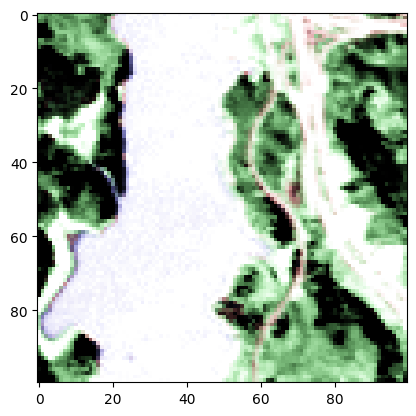

In [9]:
plt.imshow(gt)

In [10]:
img_hsi_reshaped = img_hsi.reshape(-1, img_sri.shape[-1])
gt_reshaped = gt.reshape(-1, gt.shape[-1])
print(img_hsi_reshaped.shape, gt_reshaped.shape)

(10000, 224) (10000, 4)


(10000,)
Class 0
(753,)
Class 1
(2428,)
Class 2
(3326,)
Class 3
(3493,)


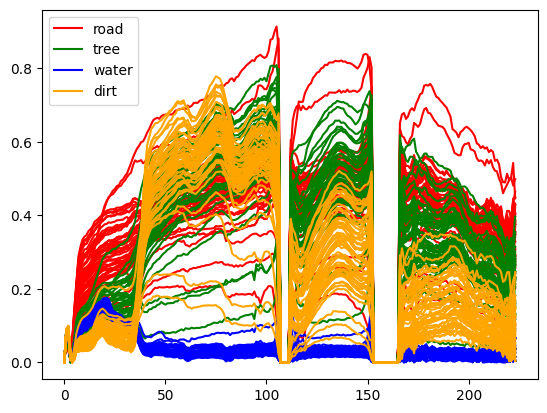

In [11]:
size_each_class = 50
color = 3
colors = ['red', 'green', 'blue', 'orange']
label_names = ['road', 'tree', 'water', 'dirt']
num_classes = 4
indices = None
all_labels = np.argmax(gt_reshaped, axis=1)
print(all_labels.shape)
for c in range(num_classes):
    print('Class', c)
    indices_in_class = np.where(all_labels == c)[0]
    print(indices_in_class.shape)
    current_choices = np.random.choice(indices_in_class, size=size_each_class)
    if indices is None:
        indices = current_choices
    else:
        indices = np.append(indices, current_choices)
num_series = indices.shape[0]
num_pixels = img_hsi_reshaped.shape[0]
num_channels = img_hsi_reshaped.shape[1]
x =  np.arange(start=0, stop=num_channels, step=1)
cnt = 0
plotted = [False]*4
for i in indices:
    color_index = all_labels[i]
    if not plotted[color_index]:
        plotted[color_index] = True
        plt.plot(x, img_hsi_reshaped[i], c=colors[color_index], label=label_names[color_index])
    else:
        plt.plot(x, img_hsi_reshaped[i], c=colors[color_index])
plt.legend()

In [12]:
from motion_code.motion_code import MotionCode
from motion_code.data_processing import load_data, process_data_for_motion_codes

all_num_series = img_hsi_reshaped.shape[0]
Y_train_all = img_hsi_reshaped.reshape(all_num_series, 1, -1)
Y_train = img_hsi_reshaped[indices, :].reshape(num_series, 1, -1)
labels_train_all = np.argmax(gt_reshaped, axis=1)
labels_train = np.argmax(gt_reshaped[indices, :], axis=1)
print(Y_train.shape, labels_train.shape)

# Then we process the data for motion code model and generate X-variable, which is needed for training.
X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)
X_train_all, Y_train_all, labels_train_all = process_data_for_motion_codes(Y_train_all, labels_train_all)
print(X_train.shape, Y_train.shape, labels_train.shape)
print(X_train_all.shape, Y_train_all.shape, labels_train_all.shape)

(200, 1, 224) (200,)
(200, 224) (200, 224) (200,)
(10000, 224) (10000, 224) (10000,)


In [13]:
# Next we build the default motion code model for both forecasting and classification
model = MotionCode(m=12, Q=1, latent_dim=2, sigma_y=0.1)

# Then we train model on the given X_train, Y_train, label_train set and saved it to a file named test_model.
model_path = 'motion_code/saved_models/' + 'test_model'
model.fit(X_train, Y_train, labels_train, model_path)

In [13]:
from motion_code.motion_code import MotionCode
model = MotionCode(m=12, Q=1, latent_dim=2, sigma_y=0.1)

In [14]:
model_path = 'motion_code/saved_models/test_model'
model.load(model_path)

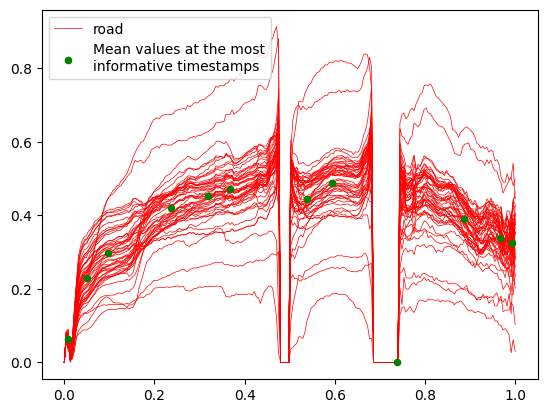

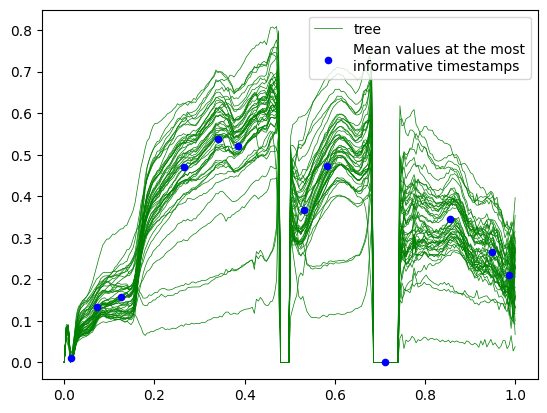

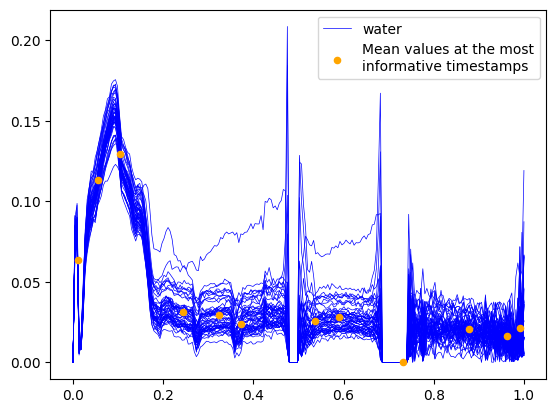

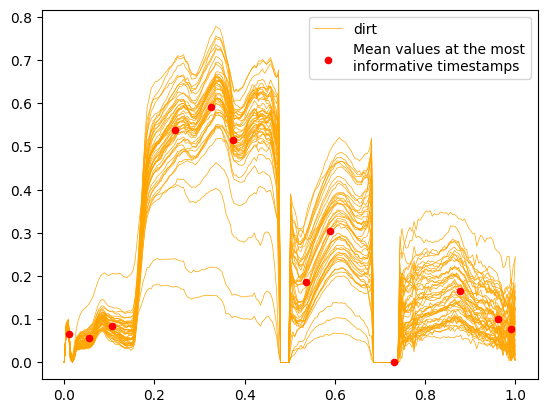

<Figure size 640x480 with 0 Axes>

In [102]:
from motion_code.utils import plot_motion_codes
plot_motion_codes(X_train, Y_train, test_time_horizon=None, labels=labels_train, label_names=label_names,
                           model=model, output_dir='motion_code/out/multiple/', additional_data=None)

In [76]:
from motion_code.sparse_gp import sigmoid
import numpy as np
num_motion = 4; m = 12
X_m, Z = model.X_m, model.Z
X_m_ks = [sigmoid(X_m @ Z[k]) for k in range(num_motion)]
X_m_ks = np.array(X_m_ks)
Y_means_at_X_m = np.zeros((num_motion, m))
Y_stds_at_X_m = np.zeros((num_motion, m))
Y_list_at_X_m = []
for _ in range(num_motion):
  Y_list_at_X_m.append([])
for X_s, Y_s, label in zip(X_train, Y_train, labels_train):
  Y_list_at_X_m[label].append(np.interp(X_m_ks[label], X_s, Y_s))
for k in range(num_motion):
  tmp = np.array(Y_list_at_X_m[k])
  Y_means_at_X_m[k] = np.mean(tmp, axis=0)
  Y_stds_at_X_m[k] = np.std(tmp, axis=0)

In [103]:
X_m_ks[0] * 224

array([  1.929069,  11.189465,  21.869465,  53.1529  ,  71.23139 ,
        82.51453 , 120.40706 , 133.03575 , 165.44647 , 198.49806 ,
       216.41289 , 222.32718 ], dtype=float32)

In [77]:
Y_means_at_X_m[0]

array([0.06279615, 0.23062708, 0.29708423, 0.41920307, 0.45289897,
       0.47052191, 0.44493869, 0.48852557, 0.        , 0.39123785,
       0.33768697, 0.32405536])

In [78]:
Y_means_at_X_m[1]

array([0.01102192, 0.13294761, 0.15871009, 0.4703246 , 0.53798779,
       0.52135811, 0.36716206, 0.47193943, 0.        , 0.34601542,
       0.26616394, 0.21134307])

In [79]:
Y_means_at_X_m[2]

array([0.06351   , 0.11316142, 0.12970848, 0.03108802, 0.02958439,
       0.02370405, 0.0256361 , 0.02799001, 0.        , 0.02101904,
       0.01626652, 0.02161544])

In [80]:
Y_means_at_X_m[3]

array([0.06599283, 0.05601498, 0.08495281, 0.539033  , 0.59056758,
       0.51552567, 0.18541487, 0.30528529, 0.        , 0.16610751,
       0.10075308, 0.0779781 ])

In [54]:
Y_stds_at_X_m[1]

array([0.01190038, 0.07798751, 0.10084134, 0.21905403, 0.2433919 ,
       0.22083206, 0.17985292, 0.20144322, 0.        , 0.17147687,
       0.14529769, 0.12969488])

In [23]:
Y_means_at_X_m.shape

(4, 12)

In [113]:
from tqdm import tqdm

indices_set = [2, 3, 4, 5, 6, 7]

def classify_predict(X_test, Y_test, X_m_ks, Y_means_at_X_m, Y_stds_at_X_m,
                     num_motion, indices_set=indices_set):
    min_err = 1e9
    label = -1
    for k in range(num_motion):
        Y_tmp = np.interp(X_m_ks[k][indices_set], X_test, Y_test)
        err_arr = (Y_tmp - Y_means_at_X_m[k][indices_set]) #/Y_stds_at_X_m[k][indices_set]
        # print(err_arr.shape)
        err = np.mean(np.abs(err_arr))
        if err < min_err:
            min_err = err
            label = k
    return label

def classify_predict_on_batches(model, X_m_ks, X_test_list,
                                Y_test_list, true_labels,
                                Y_means_at_X_m,
                                Y_stds_at_X_m,
                                num_motion):
    # Predict each trajectory/timeseries in the test dataset
    num_predicted = 0
    pred = []; gt = []
    if isinstance(Y_test_list, list):
        num_test = len(Y_test_list)
    else:
        num_test = Y_test_list.shape[0]
    pbar = tqdm(zip(X_test_list, Y_test_list), total=num_test, leave=False)
    num_predicted = 0
    for X_test, Y_test in pbar:
        # Get predict and ground truth motions
        pred_label = classify_predict(X_test, Y_test, X_m_ks, Y_means_at_X_m, Y_stds_at_X_m, num_motion)
        gt_label = true_labels[num_predicted]
        pbar.set_description(f'Predict: {pred_label}; gt: {gt_label}')
        # Append results to lists for final evaluation
        pred.append(pred_label); gt.append(gt_label)
        num_predicted += 1
    pred = np.array(pred); gt = np.array(gt)
    print(np.sum(pred==gt)/pred.shape[0])
    return pred, gt

In [114]:
# Prediction on data
# Now we can go on to perform prediction on the whole test set and get accuracy
pred, gt = classify_predict_on_batches(model, X_m_ks, X_train_all, Y_train_all,
                                       labels_train_all, Y_means_at_X_m,
                                       Y_stds_at_X_m, num_motion)

0.9098


In [116]:
pred, gt = np.array(pred).reshape(100, 100), np.array(gt).reshape(100, 100)

In [107]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green', 'blue', 'orange'])

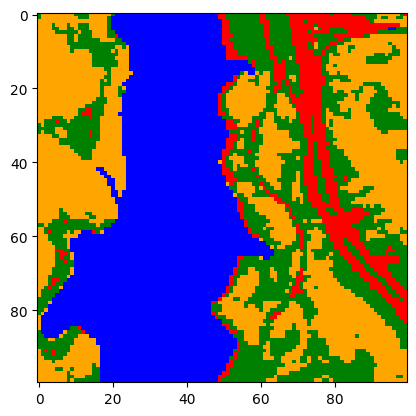

In [117]:
plt.imshow(pred, cmap=cmap)

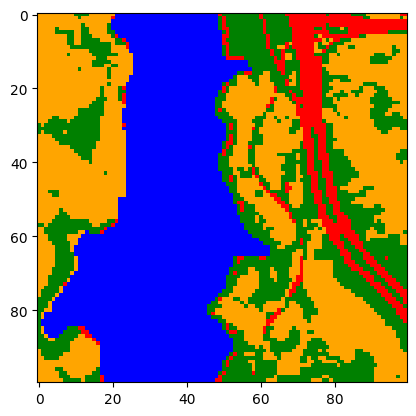

In [118]:
plt.imshow(gt, cmap=cmap)